In [27]:
import os
import pandas as pd
import numpy as np
from io import StringIO
import seaborn as sns
import matplotlib.pyplot as plt

In [9]:
def read_csv_with_errors(file_path):
        with open(file_path, 'r', encoding='utf-8', errors='replace') as file:
            return pd.read_csv(StringIO(file.read()), header=None)

def calculate_overlap(file_path_1, file_path_2):
    #print(file_path_1, file_path_2)
    data_1 = read_csv_with_errors(file_path_1)
    data_2 = read_csv_with_errors(file_path_2)
    
    # remove duplicate usernames
    unique_names_1 = set(data_1[0].str.strip())
    unique_names_2 = set(data_2[0].str.strip())
    
    # Jaccard Similarity
    overlap = unique_names_1.intersection(unique_names_2)
    overlap_size = len(overlap)
    union_size = len(unique_names_1.union(unique_names_2))
    normalized_overlap = overlap_size / union_size
    percent_overlap = round(normalized_overlap * 100, 5)
    
    return percent_overlap, overlap_size, union_size

In [10]:
def generate_df(folder_path):
    file_names = [f for f in os.listdir(folder_path) if f.endswith(".csv")]
    overlap_df = pd.DataFrame(index=file_names, columns=file_names)
    
    for i, file_1 in enumerate(file_names):
        for j, file_2 in enumerate(file_names):
            if i != j:
                file_path_1 = os.path.join(folder_path, file_1)
                file_path_2 = os.path.join(folder_path, file_2)
                
                overlap = calculate_overlap(file_path_1, file_path_2)
                
                overlap_df.at[file_1, file_2] = overlap
            else:
                overlap_df.at[file_1, file_2] = None

    # remove ".csv"
    overlap_df.index = [name.replace('.csv', '') for name in overlap_df.index]
    overlap_df.columns = [name.replace('.csv', '') for name in overlap_df.columns]
    
    return overlap_df

In [11]:
df1 = generate_df("Channels")

In [13]:
def get_sorted_values(df):
    processed_pairs = set()
    values_with_names = []
    
    for row in range(df.shape[0]):
        for col in range(df.shape[1]):
            # don't repeat B+A when A+B is already processed
            if (df.index[row], df.columns[col]) not in processed_pairs and \
               (df.columns[col], df.index[row]) not in processed_pairs:
                
                value = df.iat[row, col]
                if pd.notna(value):
                    values_with_names.append((value, df.index[row], df.columns[col]))
                    processed_pairs.add((df.index[row], df.columns[col]))

    # descending order
    sorted_values_with_names = sorted(values_with_names, key=lambda x: x[0], reverse=True)
    return sorted_values_with_names

In [14]:
df1_sorted = get_sorted_values(df1)
df1_sorted[:10]

[((11.24761, 19026, 169156), 'IHincognitoMode', 'InternetHistorian'),
 ((5.81083, 1491, 25659), 'illusorywall', 'ZullietheWitch'),
 ((2.65715, 2920, 109892), 'TechnologyConnections', 'theslowmoguys'),
 ((2.62095, 3341, 127473), 'CGPGrey', 'TechnologyConnections'),
 ((2.54671, 7299, 286605), 'IHincognitoMode', 'RedLetterMedia'),
 ((2.43704, 7596, 311690), 'InternetHistorian', 'RedLetterMedia'),
 ((2.41838, 3922, 162175), 'NileRed', 'Vsauce'),
 ((2.22135, 2986, 134423), 'IHincognitoMode', 'videogamedunkey'),
 ((2.10493, 3356, 159435), 'InternetHistorian', 'videogamedunkey'),
 ((2.01641, 2860, 141836), 'CGPGrey', 'IHincognitoMode')]

In [15]:
df2 = generate_df("Channels/hermits")
df2_sorted = get_sorted_values(df2)

In [16]:
df2_sorted[:10]

[((16.68037, 3247, 19466), 'impulseSV', 'MCSkizzleman'),
 ((16.15988, 4326, 26770), 'impulseSV', 'TangoTekLP'),
 ((14.80588, 5095, 34412), 'bdoubleo', 'TangoTekLP'),
 ((14.74662, 4269, 28949), 'docm77', 'TangoTekLP'),
 ((14.41377, 3425, 23762), 'MCSkizzleman', 'TangoTekLP'),
 ((14.13076, 3257, 23049), 'GeminiTayMC', 'PearlescentMoon'),
 ((13.98757, 3016, 21562), 'impulseSV', 'PearlescentMoon'),
 ((13.71871, 14327, 104434), 'Grian', 'ThatMumboJumbo'),
 ((13.66405, 11106, 81279), 'GoodTimesWithScar', 'Grian'),
 ((13.65296, 5832, 42716), 'GoodTimesWithScar', 'TangoTekLP')]

In [42]:
def create_heatmap(df, filename=None):
    df_values = df.applymap(lambda x: x[0] if isinstance(x, tuple) else x)
    plt.figure(figsize=(10, 8))
    mask = np.triu(np.ones_like(df, dtype=bool))
    sns.heatmap(df_values, mask=mask, annot=False, cmap="YlGnBu", cbar=True)
    plt.title('Jaccard Similarity Heatmap')

    if filename:
        filename += '.png'
        full_path = os.path.join("heatmaps", filename)
        plt.savefig(full_path, bbox_inches='tight', dpi=300)
    
    plt.show()

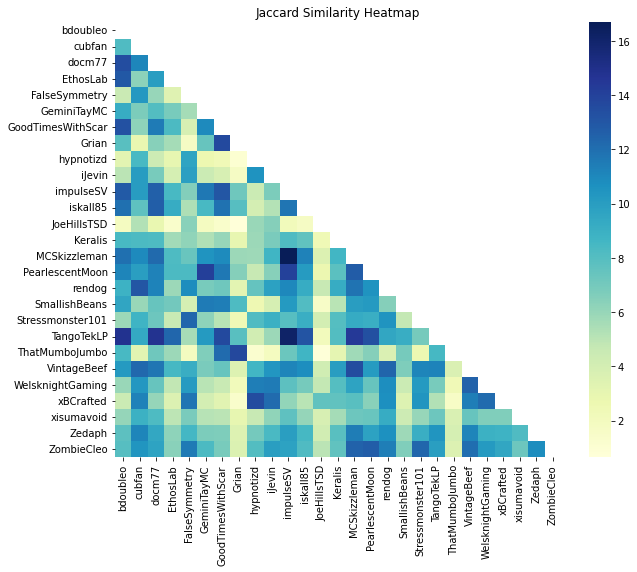

In [43]:
create_heatmap(df2, "hermits")

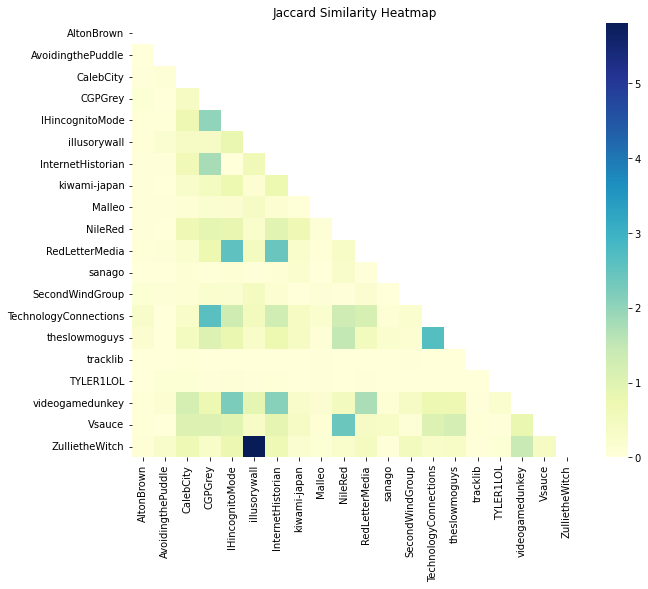

In [45]:
# remove outlier between 'IHincognitoMode' and 'InternetHistorian'
# high overlap because both channels are run by the same person
df1.loc['IHincognitoMode', 'InternetHistorian'] = 0
df1.loc['InternetHistorian', 'IHincognitoMode'] = 0
# fill that square in manually in paint

create_heatmap(df1, "df1")

Jaccard Similarity\
∣A∪B∣ / ∣A∩B∣\
∣A∩B∣ = number of common names\
∣A∪B∣ = total number of unique names across both lists\